# TODO 
- Najdi activation function sho e slichen na relu ama da davat negativni vrednosti.
- Razmisli za LSTM kako ke go napresh.  

# Scripts

In [22]:
%run '../shared-code/utils.py'

# Dependencies

In [116]:
import pandas as pd 
import tensorflow as tf 
import tensorflow.keras as keras 
import joblib
import tensorflow.math as tf_math
import numpy as np 
import matplotlib.pyplot as plt 
from tensorflow.keras.initializers import GlorotUniform


%matplotlib inline 

# Utils

$$RMSLE=\sqrt{\frac{1}{n}\sum_{i=1}^{n}(log(y_{i}+1) - log(\^{y_{i}}+1))^{2}}$$

In [143]:
def cast_tesnor(tensor: tf.Tensor):
    if tensor.dtype != tf.float32:
        return tf.cast(tensor, dtype=tf.float32)
    return tensor


def tf_rmsle(y_true, y_pred):
    y_true = cast_tesnor(y_true)
    y_pred = cast_tesnor(y_pred)

    return tf.sqrt(
        tf_math.reduce_mean(
            tf_math.pow(tf_math.log(y_true + 1) - tf_math.log(y_pred + 1), 2)
        )
    )

def train_nn(
    nn: keras.Sequential,
    X: pd.DataFrame,
    y: pd.DataFrame,
    epochs: list,
    figsize: tuple[int, int] = (50, 20),
    should_print_epoch_losses: bool = False,
    should_print_summary: bool = False,
):
    if should_print_summary:
        print(nn.summary())

    nn.compile(optimizer="adam", loss=tf_rmsle, metrics=[tf_rmsle])

    hist = nn.fit(
        x=X, y=y, epochs=epochs, batch_size=32, validation_split=0.25, shuffle=False
    )

    if should_print_epoch_losses:
        epochs = list(range(epochs))

        plt.figure(figsize=(50,20))
        plt.title("Loss/Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")

        plt.plot(epochs,hist.history['val_loss'],label='Validation')
        plt.plot(epochs,hist.history['loss'],label='Train')

        plt.legend() 
        plt.show() 

# Load & Process 

In [25]:
pipe_data=joblib.load('../pipelines/data_pipeline.pkl')
df_tr=pd.read_csv('../data/train.csv')
df_tst=pd.read_csv('../data/test.csv')
X_tr,Y_tr=df_tr.drop(TARGET_COL,axis=1),df_tr[TARGET_COL]
X_tst,Y_tst=df_tst.drop(TARGET_COL,axis=1),df_tst[TARGET_COL]

In [26]:
X_tr_proc,X_tst_proc=pipe_data.transform(X_tr),pipe_data.transform(X_tst)

# Ordinary

Vo posledniot layer sekogash ke koristime Relu deka outputot ne smet da ni e nekoja vrednost < 0. 

Epoch 1/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.7310 - tf_rmsle: 5.7297 - val_loss: 3.7488 - val_tf_rmsle: 3.7605
Epoch 2/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5553 - tf_rmsle: 3.5550 - val_loss: 3.1533 - val_tf_rmsle: 3.1629
Epoch 3/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0018 - tf_rmsle: 3.0015 - val_loss: 2.6471 - val_tf_rmsle: 2.6550
Epoch 4/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5039 - tf_rmsle: 2.5036 - val_loss: 2.1686 - val_tf_rmsle: 2.1747
Epoch 5/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0363 - tf_rmsle: 2.0361 - val_loss: 1.7367 - val_tf_rmsle: 1.7410
Epoch 6/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6234 - tf_rmsle: 1.6232 - val_loss: 1.3778 - val_tf_rmsle: 1.3811
Epoch 7/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2837 - tf_rmsle: 1.2835 - val_loss: 1.0873 - val_tf_rmsle: 1.0897
Epoch 8/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0081 - tf_rmsle: 1.0080 - val_loss: 0.8507 - val_tf_rmsle:

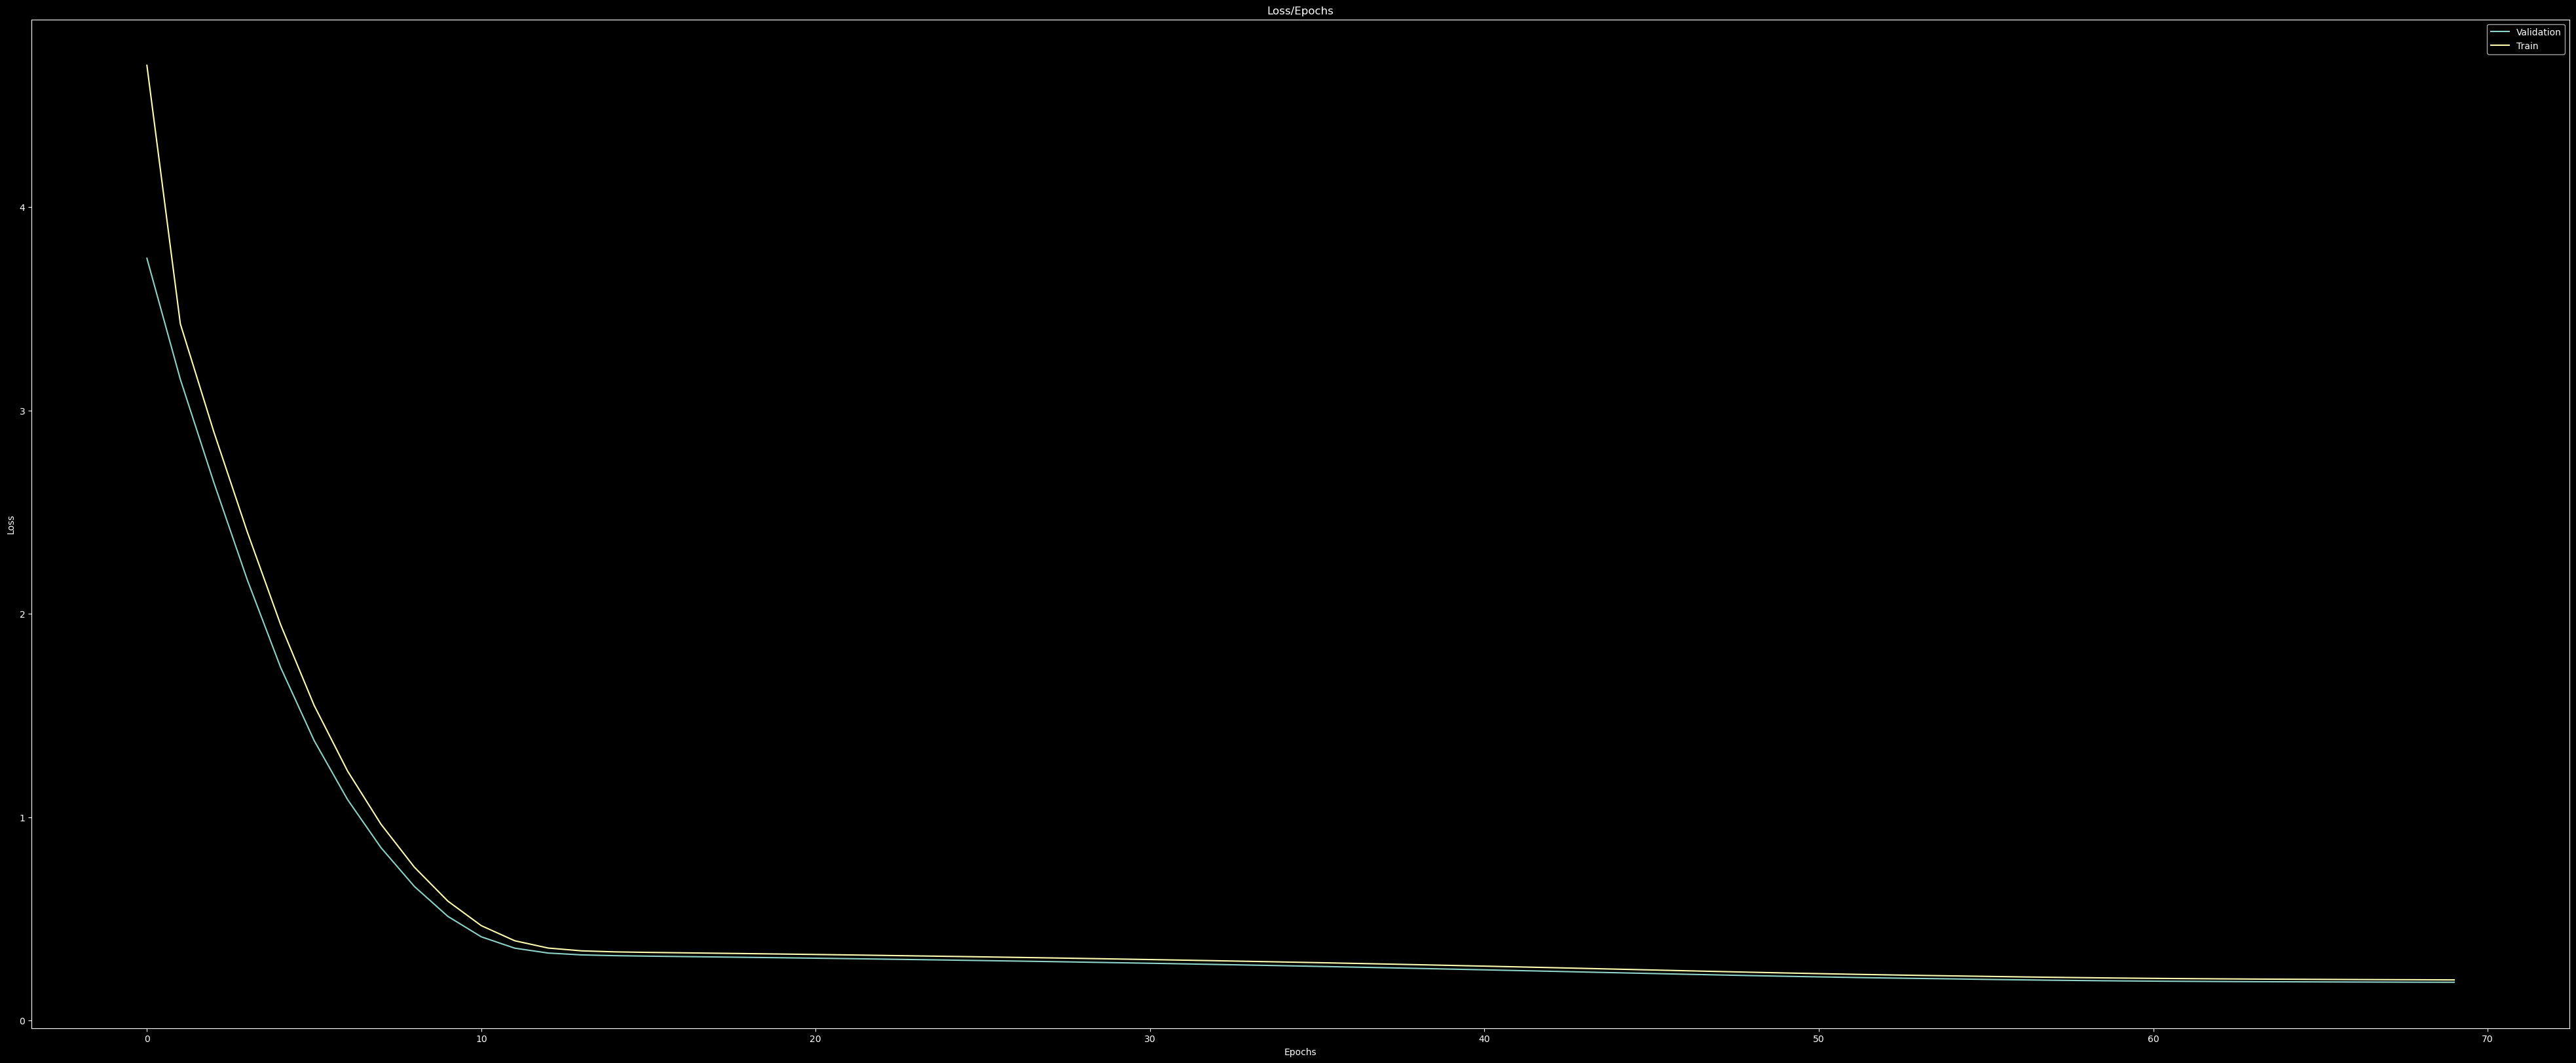

In [144]:
train_nn(
    nn=keras.Sequential(
        [
            keras.layers.Input((X_tr_proc.shape[1],)),
            keras.layers.Dense(50,kernel_initializer=GlorotUniform(42),activation=keras.activations.selu),
            keras.layers.Dense(50,kernel_initializer=GlorotUniform(42),activation=keras.activations.selu),
            keras.layers.Dense(1, kernel_initializer=GlorotUniform(42)),
            keras.layers.ReLU() 
        ]
    ),
    X=X_tr_proc,
    y=Y_tr,
    epochs=70,
    should_print_epoch_losses=True,
)

# LSTM 

# Test dataset